In [4]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Decadal variability of WMT in GFDL's OM4
JRA forcing  

14/10/20
- check forcing signs etc. Am I getting this right? Confirm salt budget closure.
- surface forcing only? what terms do I need, and which are there? Gustavo tutorial may indicate this.
- necessity of monthly output

Budget closure issues

- SALT budget has residual noise - most likely because of salt restoring, diagnostics for which are not available
    - not true in fact, since restoring is including in buoyancy forcing
    - noise remains undiagnose
- HEAT budget has residual associated with geothermal heat - internal_heat_heat_tendency not included as diagnostic
- SALT tendencies are, in fact, NEGATIVE salt tendencies, - see for example, the boundary forcing at rivers, where positive salt tendencies are found in regions corresponding to positive freshwater fluxes, i.e. negative salt fluxes. CONFIRM THIS IN THE SOURCE CODE.
    - This, in fact, is not the case. Instead, it looks as though the _restoring_ is dominating the forcing, and driving the solution back to climatology. This makes it look as though the tendencies are of the opposite sign from what we expect (based on surface flux knowledge).
    
So, again, it seems that I need to redo the simulation from a restart, and output the diagnostic for the restoring separately.

In [5]:
import xarray as xr
import numpy as np
from matplotlib import pyplot as plt
from xhistogram.xarray import histogram
import gsw
import wmt_bgc.basic as wmt
import fastjmd95 as jmd95
from xgcm import Grid
%matplotlib inline

In [6]:
# Load the data
# (from restart)
config = 'OM4p25_JRA55do1.4_0netfw_cycle6'
rootdir = '/archive/Raphael.Dussin/xanadu_esm4_20190304_mom6_2019.08.08/'+config+'/gfdl.ncrc4-intel16-prod/pp/'
pp = 'ocean_annual_z'
localdir = '/ts/annual/5yr/'
filename = pp+'.*.nc'
ds = xr.open_mfdataset(rootdir+pp+localdir+filename)
grid = xr.open_dataset(rootdir+pp+'/'+pp+'.static.nc')
# Load gamma_n
gammadir = '/archive/gam/so_decadal_variability/OM4p25_JRA55do1.4_0netfw_cycle6/'
localdir = '/'
ds = xr.merge([ds,xr.open_mfdataset(gammadir+pp+localdir+filename)['gamma_n']])
ds['gamma_n'] = ds['gamma_n'].where(ds['gamma_n']>0,np.nan)
# Specify some constants
Cp = 3992.
rho0 = 1035.

In [7]:
# Build an xgcm grid object
# Create a pseudo-grid in the vertical
grid['z_l'] = ds['z_l']
grid['z_i'] = ds['z_i']
grid['dzt'] = grid['z_l'].copy(data=grid['z_i'].diff('z_i'))
grid = grid.squeeze() # Get rid of any remnant time variables

# Fill in nans with zeros
grid['dxt'] = grid['dxt'].fillna(0.)
grid['dyt'] = grid['dyt'].fillna(0.)
grid['dzt'] = grid['dzt'].fillna(0.)
grid['areacello'] = grid['areacello'].fillna(0.)
grid['volcello'] = ds['volcello'].fillna(0.)
metrics = {
    ('X',): ['dxt','dxCu','dxCv'], # X distances
    ('Y',): ['dyt','dyCu','dyCv'], # Y distances
    ('Z',): ['dzt'], # Z distances
    ('X', 'Y'): ['areacello'], # Areas
    ('X', 'Y', 'Z'): ['volcello'], # Volumes
}
coords={'X': {'center': 'xh', 'right': 'xq'},
        'Y': {'center': 'yh', 'right': 'yq'},
        'Z': {'center': 'z_l', 'outer': 'z_i'} }
xgrid = Grid(grid, coords=coords, metrics=metrics, periodic=['X'])

In [8]:
# Specifications for heat and salt budgets
variables = {'heat':'thetao','salt':'so'}
processes=['boundary forcing','vertical diffusion','neutral diffusion',
           'frazil ice','internal heat']
terms = {}
terms['heat'] = {'boundary forcing':'boundary_forcing_heat_tendency',
         'vertical diffusion':'opottempdiff',
         'neutral diffusion':None,
         'frazil ice':'frazil_heat_tendency',
         'internal heat':None}
terms['salt'] = {'boundary forcing':'boundary_forcing_salt_tendency',
         'vertical diffusion':'osaltdiff',
         'neutral diffusion':'osaltpmdiff',
         'frazil ice':None,
         'internal heat':None}

In [9]:
# Preprocess
# Isolate Southern Ocean
ds_SO = ds.sel(yh=slice(-90,-30),yq=slice(-90,-30))

# Pressure from depth
ds_SO['p'] = wmt.gsw_p_from_z(-ds_SO['z_l'],grid['geolat'])

# Calculate density
density = 'gamma_n'
if density=='sigma0':
    ### sigma0
    # Calculate density
    ds_SO['density'] = wmt.gsw_sigma0(ds_SO['so'],ds_SO['thetao'])
    # Calculate alpha and beta
    alpha = wmt.gsw_alpha(ds_SO['so'],ds_SO['thetao'],ds_SO['p'])
    beta = wmt.gsw_beta(ds_SO['so'],ds_SO['thetao'],ds_SO['p'])
elif density=='jmd95':
    ### jmd95
    # Calculate density
    ds_SO['density'] = jmd95.rho(ds_SO['so'],ds_SO['thetao'],ds_SO['p'])
    # Calculate alpha and beta
    alpha = jmd95.drhodt(ds_SO['so'],ds_SO['thetao'],ds_SO['p'])
    beta = jmd95.drhods(ds_SO['so'],ds_SO['thetao'],ds_SO['p'])
elif density=='mjd05':
    ### mjd05
    # Calculate density
    ds_SO['density'] = wmt.sigmantr_mjd05(ds_SO['so'],ds_SO['thetao'])
    # Calculate alpha and beta
    alpha = wmt.gsw_alpha(ds_SO['so'],ds_SO['thetao'],ds_SO['p'])
    beta = wmt.gsw_beta(ds_SO['so'],ds_SO['thetao'],ds_SO['p'])
elif density=='gamma_n':
    ### mjd05
    # Calculate density
    ds_SO['density'] = ds['gamma_n']
    # Calculate alpha and beta
    alpha = wmt.gsw_alpha(ds_SO['so'],ds_SO['thetao'],ds_SO['p'])
    beta = wmt.gsw_beta(ds_SO['so'],ds_SO['thetao'],ds_SO['p'])
    
# Interpolate density to the cell interfaces
ds_SO['density_i'] = xgrid.interp(ds_SO['density'],'Z',boundary='extrapolate').chunk({'z_i':-1})

/nbhome/gam/miniconda/envs/mom6-clean/lib/python3.8/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


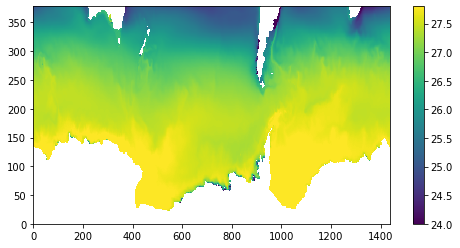

In [10]:
fig,ax=plt.subplots(figsize=(8,4))
im=ax.pcolormesh(ds_SO['density'].isel(z_l=0).mean('time'),vmin=24,vmax=27.8)
plt.colorbar(im,ax=ax)

### Checking budget closure

In [33]:
# Check salt budget closure

# Define a function to sum up the terms on the LHS and RHS of the tracer
# conservation equation
def calc_budget(ds,terms):
    lhs = xr.Dataset()
    rhs = xr.Dataset()
    for key in terms.keys():
        lhs[key] = xr.zeros_like(ds[terms[key][0]])
        for term in terms[key][0:3]:
            # Flip the sign for the advective tendencies
            if term in ['opottemptend','osalttend','dhdt']:
                sign=1
            else:
                sign=-1
            lhs[key] += sign*ds[term]
        rhs[key] = xr.zeros_like(ds[terms[key][3]])
        for term in terms[key][3:]:
            sign=1
            rhs[key] += sign*ds[term]
    return lhs, rhs

termsnow = {}
termsnow['heat'] = ['opottemptend','T_advection_xy','Th_tendency_vert_remap',
                 'boundary_forcing_heat_tendency','opottempdiff',
                 'frazil_heat_tendency']
termsnow['salt'] = ['osalttend','S_advection_xy','Sh_tendency_vert_remap',
                 'boundary_forcing_salt_tendency','osaltdiff','osaltpmdiff']
lhs,rhs = calc_budget(ds,termsnow)

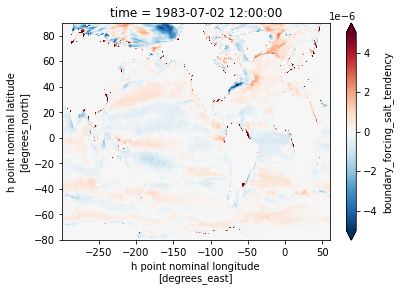

In [63]:
ds['boundary_forcing_salt_tendency'].isel(time=25).sum('z_l').plot(vmin=-0.5E-5)

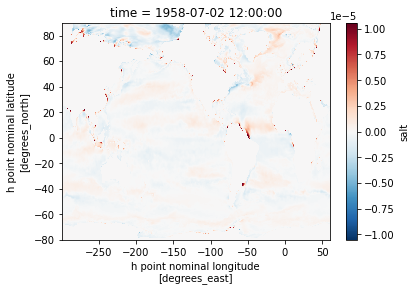

In [43]:
rhs['salt'].isel(time=0).sum('z_l').plot()

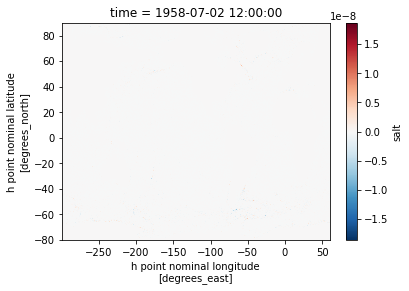

In [44]:
(lhs['salt']-rhs['salt']).isel(time=0).sum('z_l').plot()

In [50]:
# Define a short function to calculate the tendency
# of the locally-referenced potential density
# from heat and salt content tendencies
def densitytendency_from_heat_and_salt(
    heat_tend,salt_tend,alpha=1E-4,beta=1E-3,Cp=3992.0):

    densitytendency_heat = -(alpha/Cp)*heat_tend
    densitytendency_salt = -beta*salt_tend*1000 # Factor of 1000 converts salt_tend to g m-2 s-1
    densitytendency = densitytendency_heat + densitytendency_salt
    return densitytendency, densitytendency_heat, densitytendency_salt

Todo
- come up with a more robust way of specifying the direction of heat of salt fluxes
- It looks like there's something wrong with the salt flux. It's impact on density is positive where it should be negative.
- revisit densitytendency from heat and salt - is it correct?
- could it be the calculation of alpha and beta?

In [51]:
# Calculate density tendency
drhodt = xr.Dataset()
drhodt_heat = xr.Dataset()
drhodt_salt = xr.Dataset()
for process in processes:
    term_heat = terms['heat'][process]
    term_salt = terms['salt'][process]

    # If there is no contribution of heat or salt for this process,
    # set to zero. A little hacky, requiring that the first process
    # is non-zero for both heat and salt.
    if term_heat is not None:
        heat_tend = ds_SO[term_heat]
    else:
        heat_tend = xr.zeros_like(ds_SO[terms['heat'][processes[0]]])

    if term_salt is not None:
        salt_tend = ds_SO[term_salt]
    else:
        salt_tend = xr.zeros_like(ds_SO[terms['salt'][processes[0]]])

    (drhodt[process],
     drhodt_heat[process],
     drhodt_salt[process]) = densitytendency_from_heat_and_salt(
        heat_tend,
        salt_tend,
        alpha=alpha,
        beta=beta,Cp=Cp)

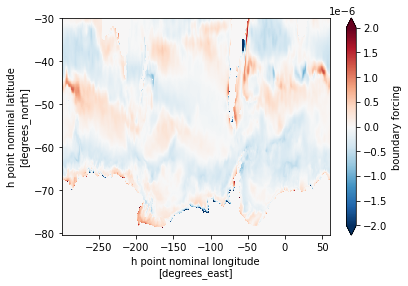

In [52]:
# Check signs
drhodt_salt['boundary forcing'].sum('z_l').mean('time').plot(vmin=-2E-6)

In [53]:
#### B-FACTOR ###
b = xr.ones_like(ds_SO['density'])

In [54]:
# Specify the tracer range and bin widths (\delta\lambda) for the calculation
delta_l = 0.1
lmin = 26
lmax = 28.5
bins = np.arange(lmin,lmax,delta_l)

Todo: 
- b-factor *also* needs to be transformed, so order in which you specify the integrand is important

In [55]:
# Transform each of the diffusive tendency terms onto the density grid
# And integrate in each temperature layer and divide by \delta density
G = xr.Dataset()
for process in processes:
    var_on_dens = xgrid.transform(
        drhodt[process],'Z',target=bins,target_data=ds_SO['density_i'],method='conservative')
    G[process] = (
        (rho0*var_on_dens)*grid['areacello']).sum(['xh','yh'])/np.diff(bins)
G['total'] = xr.zeros_like(G[processes[0]])
for process in processes:
    G['total'] += G[process]

In [60]:
# Separately evaluate for heat-driven and salt-driven
# HEAT
G_heat = xr.Dataset()
for process in processes:
    var_on_dens = xgrid.transform(
        drhodt_heat[process],'Z',target=bins,target_data=ds_SO['density_i'],method='conservative')
    G_heat[process] = (
        (rho0*var_on_dens)*grid['areacello']).sum(['xh','yh'])/np.diff(bins)
# SALT
G_salt = xr.Dataset()
for process in processes:
    var_on_dens = xgrid.transform(
        drhodt_salt[process],'Z',target=bins,target_data=ds_SO['density_i'],method='conservative')
    G_salt[process] = (
        (rho0*var_on_dens)*grid['areacello']).sum(['xh','yh'])/np.diff(bins)

In [62]:
%%time
G.load()
G_heat.load()
G_salt.load()

CPU times: user 9min 44s, sys: 10min 49s, total: 20min 34s
Wall time: 3min 7s


<xarray.Dataset>
Dimensions:             (density_i: 24, time: 60)
Coordinates:
  * time                (time) object 1958-07-02 12:00:00 ... 2017-07-02 12:0...
  * density_i           (density_i) float64 26.05 26.15 26.25 ... 28.25 28.35
Data variables:
    boundary forcing    (time, density_i) float64 -1.516e+09 ... 6.656e+07
    vertical diffusion  (time, density_i) float64 1.995e+09 ... 2.423e+07
    neutral diffusion   (time, density_i) float64 0.0 0.0 0.0 ... 0.0 0.0 0.0
    frazil ice          (time, density_i) float64 0.0 0.0 0.0 ... 0.0 0.0 0.0
    internal heat       (time, density_i) float64 0.0 0.0 0.0 ... 0.0 0.0 0.0

CPU times: user 254 ms, sys: 188 ms, total: 442 ms
Wall time: 441 ms


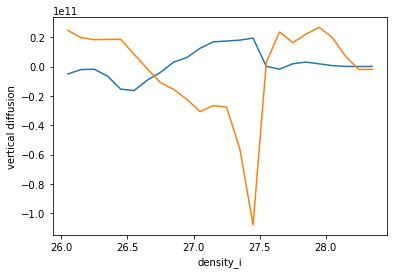

In [61]:
%%time
G_heat['boundary forcing'].isel(time=slice(0,10)).mean('time').plot()
G_heat['vertical diffusion'].isel(time=slice(0,10)).mean('time').plot()

CPU times: user 254 ms, sys: 188 ms, total: 442 ms
Wall time: 441 ms


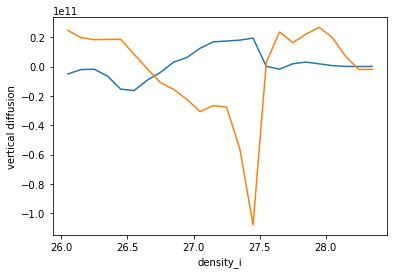

In [61]:
%%time
G_salt['boundary forcing'].isel(time=slice(0,10)).mean('time').plot()
G_salt['vertical diffusion'].isel(time=slice(0,10)).mean('time').plot()

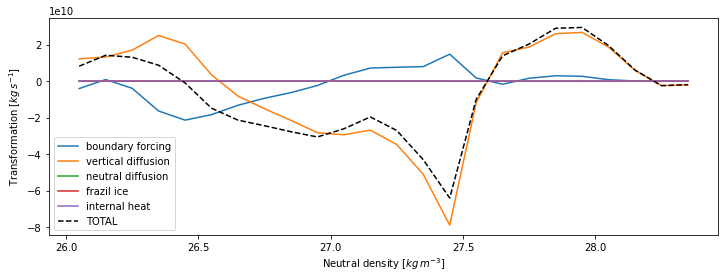

In [166]:
fig, ax = plt.subplots(figsize=(12,4))
G['total'] = xr.zeros_like(G[processes[0]].mean('time'))
for process in processes:
    ax.plot(G['density_i'],G[process].mean('time'),label=process)
    G['total'] += G[process].mean('time')
ax.plot(G['density_i'],G['total'],color='k',linestyle='--',label='TOTAL')
ax.legend()
ax.set_xlabel('Neutral density [$kg\,m^{-3}$]')
ax.set_ylabel('Transformation [$kg\,s^{-1}$]');

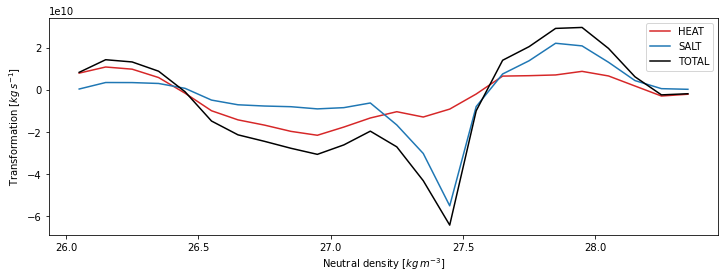

In [141]:
total = xr.zeros_like(G[processes[0]].mean('time'))
total_heat = xr.zeros_like(G_heat[processes[0]].mean('time'))
total_salt = xr.zeros_like(G_salt[processes[0]].mean('time'))
for process in processes:
    total += G[process].mean('time')
    total_heat += G_heat[process].mean('time')
    total_salt += G_salt[process].mean('time')
    
fig,ax = plt.subplots(figsize=(12,4))
ax.plot(G_heat['density_i'],total_heat,color='tab:red',linestyle='-',label='HEAT')
ax.plot(G_salt['density_i'],total_salt,color='tab:blue',linestyle='-',label='SALT')
ax.plot(G['density_i'],total,color='k',linestyle='-',label='TOTAL')
ax.legend()
ax.set_xlabel('Neutral density [$kg\,m^{-3}$]')
ax.set_ylabel('Transformation [$kg\,s^{-1}$]');

In [187]:
from dask.diagnostics import ProgressBar

In [188]:
outdir = '/work/gam/projects/so_decadal_variability/data/processed/'+config
outfile = density+'_'+str(delta_l)+'.G.nc'
with ProgressBar():
    G.to_netcdf(outdir+'/'+outfile)

[########################################] | 100% Completed |  4min  1.9s


<xarray.Dataset>
Dimensions:             (density_i: 24, time: 5)
Coordinates:
  * time                (time) object 2013-07-02 12:00:00 ... 2017-07-02 12:0...
  * density_i           (density_i) float64 26.05 26.15 26.25 ... 28.25 28.35
Data variables:
    boundary forcing    (time, density_i) float64 dask.array<chunksize=(5, 24), meta=np.ndarray>
    vertical diffusion  (time, density_i) float64 dask.array<chunksize=(5, 24), meta=np.ndarray>
    neutral diffusion   (time, density_i) float64 dask.array<chunksize=(5, 24), meta=np.ndarray>
    frazil ice          (time, density_i) float64 dask.array<chunksize=(5, 24), meta=np.ndarray>
    internal heat       (time, density_i) float64 dask.array<chunksize=(5, 24), meta=np.ndarray>